In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

In [ ]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [ ]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

In [ ]:
def extract_features(model, inputs, style_layers, content_layers):
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = model(preprocessed_input)
    style_outputs, content_outputs = (outputs[:len(style_layers)], outputs[len(style_layers):])
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
    content_dict = {content_name: value for content_name, value in zip(content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(style_layers, style_outputs)}
    return {'content': content_dict, 'style': style_dict}

In [ ]:
def style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    return style_loss + content_loss

In [ ]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
@tf.function()
def train_step(image, extractor, style_targets, content_targets, opt, style_weight, content_weight, total_variation_weight, num_style_layers, num_content_layers, style_layers, content_layers):
    with tf.GradientTape() as tape:
        outputs = extract_features(extractor, image, style_layers, content_layers)
        loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [ ]:
def run_style_transfer(content_path, style_path, lr=0.02, beta1=0.99, epsilon=1e-1, style_weight=1e-2, content_weight=1e4, tv_weight=30, iterations=500, checkpoint_iterations=100):
    content_image = load_img(content_path)
    style_image = load_img(style_path)
    opt = tf.optimizers.Adam(learning_rate=lr, beta_1=beta1, epsilon=epsilon)

    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)

    extractor = vgg_layers(style_layers + content_layers)
    style_targets = extract_features(extractor, style_image, style_layers, content_layers)['style']
    content_targets = extract_features(extractor, content_image, style_layers, content_layers)['content']
    image = tf.Variable(content_image)

    epochs = 10
    steps_per_epoch = iterations
    step = 0

    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            train_step(image, extractor, style_targets, content_targets, opt, style_weight, content_weight, tv_weight, num_style_layers, num_content_layers, style_layers, content_layers)
        if (step % checkpoint_iterations == 0):
            print('Iteration: {}'.format(step))
            tensor_to_image(image).save(f"output_{step}_iter.png")

    file_name = 'stylized-image.png'
    tensor_to_image(image).save(file_name)
    return image



In [ ]:
def display_images(content_path, style_path, generated_image):
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    content_image = tensor_to_image(content_image)
    style_image = tensor_to_image(style_image)
    generated_image = tensor_to_image(generated_image)

    fig, axs = plt.subplots(2, 2, figsize=(5, 5))

    axs[0, 0].imshow(content_image)
    axs[0, 0].set_title('Content Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(style_image)
    axs[0, 1].set_title('Style Image')
    axs[0, 1].axis('off')

    axs[1, 0].imshow(generated_image)
    axs[1, 0].set_title('Generated Image')
    axs[1, 0].axis('off')

    axs[1, 1].axis('off')

    plt.show()


content_path = '/content/content31.jpg'
style_path = '/content/style4.jpg'
# output_path = 'path_to_output_directory'

generated_image = run_style_transfer(
    content_path=content_path,
    style_path=style_path,
    lr=0.02,
    beta1=0.99,
    epsilon=1e-1,
    style_weight=1e-2,
    content_weight=1e4,
    tv_weight=30,
    iterations=5,
    checkpoint_iterations=10
)

display_images(content_path, style_path, generated_image)


ValueError: in user code:

    File "<ipython-input-9-8ba83c17733f>", line 8, in train_step  *
        opt.apply_gradients([(grad, image)])
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py", line 282, in apply_gradients  **
        self.apply(grads, trainable_variables)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py", line 321, in apply
        self.build(trainable_variables)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/adam.py", line 97, in build
        self.add_variable_from_reference(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 36, in add_variable_from_reference
        return super().add_variable_from_reference(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py", line 218, in add_variable_from_reference
        return self.add_variable(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py", line 192, in add_variable
        variable = backend.Variable(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/common/variables.py", line 165, in __init__
        self._initialize(value)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/core.py", line 31, in _initialize
        self._value = tf.Variable(

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


In [ ]:
import os

def display_images(content_path, style_path, generated_image):
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    content_image = tensor_to_image(content_image)
    style_image = tensor_to_image(style_image)
    generated_image = tensor_to_image(generated_image)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0, 0].imshow(content_image)
    axs[0, 0].set_title('Content Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(style_image)
    axs[0, 1].set_title('Style Image')
    axs[0, 1].axis('off')

    axs[1, 0].imshow(generated_image)
    axs[1, 0].set_title('Generated Image')
    axs[1, 0].axis('off')

    axs[1, 1].axis('off')

    plt.show()


image_folder = 'images'
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('jpg', 'jpeg', 'png'))]

for content_path in image_paths:
    for style_path in image_paths:
        if content_path != style_path:  # Ensure content and style images are not the same
            generated_image = run_style_transfer(
                content_path=content_path,
                style_path=style_path,
                lr=0.02,
                beta1=0.99,
                epsilon=1e-1,
                style_weight=1e-2,
                content_weight=1e4,
                tv_weight=30,
                iterations=5,
                checkpoint_iterations=10
            )

            display_images(content_path, style_path, generated_image)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import numpy as np
# import PIL.Image
# import os

# def load_img(path_to_img):
#     max_dim = 512
#     img = tf.io.read_file(path_to_img)
#     img = tf.image.decode_image(img, channels=3)
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     shape = tf.cast(tf.shape(img)[:-1], tf.float32)
#     long_dim = max(shape)
#     scale = max_dim / long_dim
#     new_shape = tf.cast(shape * scale, tf.int32)
#     img = tf.image.resize(img, new_shape)
#     img = img[tf.newaxis, :]
#     return img

# def tensor_to_image(tensor):
#     tensor = tensor * 255
#     tensor = np.array(tensor, dtype=np.uint8)
#     if np.ndim(tensor) > 3:
#         assert tensor.shape[0] == 1
#         tensor = tensor[0]
#     return PIL.Image.fromarray(tensor)

# def vgg_layers(layer_names):
#     vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
#     vgg.trainable = False
#     outputs = [vgg.get_layer(name).output for name in layer_names]
#     model = tf.keras.Model([vgg.input], outputs)
#     return model

# def gram_matrix(input_tensor):
#     result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
#     input_shape = tf.shape(input_tensor)
#     num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
#     return result / num_locations

# def extract_features(model, inputs, style_layers, content_layers):
#     inputs = inputs * 255.0
#     preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
#     outputs = model(preprocessed_input)
#     style_outputs, content_outputs = (outputs[:len(style_layers)], outputs[len(style_layers):])
#     style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
#     content_dict = {content_name: value for content_name, value in zip(content_layers, content_outputs)}
#     style_dict = {style_name: value for style_name, value in zip(style_layers, style_outputs)}
#     return {'content': content_dict, 'style': style_dict}

# def style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers):
#     style_outputs = outputs['style']
#     content_outputs = outputs['content']
#     style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])
#     style_loss *= style_weight / num_style_layers
#     content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
#     content_loss *= content_weight / num_content_layers
#     return style_loss + content_loss

# def clip_0_1(image):
#     return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# @tf.function()
# def train_step(image, extractor, style_targets, content_targets, opt, style_weight, content_weight, total_variation_weight, num_style_layers, num_content_layers, style_layers, content_layers):
#     with tf.GradientTape() as tape:
#         outputs = extract_features(extractor, image, style_layers, content_layers)
#         loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers)
#         loss += total_variation_weight * tf.image.total_variation(image)
#     grad = tape.gradient(loss, image)
#     opt.apply_gradients([(grad, image)])
#     image.assign(clip_0_1(image))

# def run_style_transfer(content_path, style_path, lr=0.02, beta1=0.99, epsilon=1e-1, style_weight=1e-2, content_weight=1e4, tv_weight=30, iterations=500, checkpoint_iterations=100):
#     content_image = load_img(content_path)
#     style_image = load_img(style_path)
#     opt = tf.optimizers.Adam(learning_rate=lr, beta_1=beta1, epsilon=epsilon)

#     content_layers = ['block5_conv2']
#     style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
#     num_content_layers = len(content_layers)
#     num_style_layers = len(style_layers)

#     extractor = vgg_layers(style_layers + content_layers)
#     style_targets = extract_features(extractor, style_image, style_layers, content_layers)['style']
#     content_targets = extract_features(extractor, content_image, style_layers, content_layers)['content']
#     image = tf.Variable(content_image)

#     epochs = 10
#     steps_per_epoch = iterations
#     step = 0

#     for n in range(epochs):
#         for m in range(steps_per_epoch):
#             step += 1
#             train_step(image, extractor, style_targets, content_targets, opt, style_weight, content_weight, tv_weight, num_style_layers, num_content_layers, style_layers, content_layers)
#         if (step % checkpoint_iterations == 0):
#             print('Iteration: {}'.format(step))
#             tensor_to_image(image).save(f"output_{step}_iter.png")

#     file_name = 'stylized-image.png'
#     tensor_to_image(image).save(file_name)
#     return image

# def display_images(content_path, style_path, generated_image):
#     content_image = load_img(content_path)
#     style_image = load_img(style_path)

#     content_image = tensor_to_image(content_image)
#     style_image = tensor_to_image(style_image)
#     generated_image = tensor_to_image(generated_image)

#     fig, axs = plt.subplots(2, 2, figsize=(10, 10))

#     axs[0, 0].imshow(content_image)
#     axs[0, 0].set_title('Content Image')
#     axs[0, 0].axis('off')

#     axs[0, 1].imshow(style_image)
#     axs[0, 1].set_title('Style Image')
#     axs[0, 1].axis('off')

#     axs[1, 0].imshow(generated_image)
#     axs[1, 0].set_title('Generated Image')
#     axs[1, 0].axis('off')

#     axs[1, 1].axis('off')

#     plt.show()

# # Get all image paths from the 'images' folder
# image_folder = 'images'
# image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('jpg', 'jpeg', 'png'))]

# for content_path in image_paths:
#     for style_path in image_paths:
#         if content_path != style_path:  # Ensure content and style images are not the same
#             generated_image = run_style_transfer(
#                 content_path=content_path,
#                 style_path=style_path,
#                 lr=0.02,
#                 beta1=0.99,
#                 epsilon=1e-1,
#                 style_weight=1e-2,
#                 content_weight=1e4,
#                 tv_weight=30,
#                 iterations=5,
#                 checkpoint_iterations=10
#             )

#             display_images(content_path, style_path, generated_image)


Applying style from images/20180828_183529.jpg to content images/20180831_110203.jpg
Iteration: 10, Loss: 23359512.0000
Iteration: 20, Loss: 18047518.0000
Iteration: 30, Loss: 15009647.0000
Iteration: 40, Loss: 13048729.0000
Iteration: 50, Loss: 11788219.0000
Iteration: 60, Loss: 10866977.0000
Iteration: 70, Loss: 10148534.0000
Iteration: 80, Loss: 9491325.0000
Iteration: 90, Loss: 8912738.0000
Iteration: 100, Loss: 8374309.5000
Saving image at iteration 100
Iteration: 110, Loss: 7883676.0000
Iteration: 120, Loss: 7431994.0000
Iteration: 130, Loss: 7012832.0000
Iteration: 140, Loss: 6629089.0000
Iteration: 150, Loss: 6262817.0000
Iteration: 160, Loss: 5931967.0000
Iteration: 170, Loss: 5635458.0000
Iteration: 180, Loss: 5358461.0000
Iteration: 190, Loss: 5106895.5000
Iteration: 200, Loss: 4872825.0000
Saving image at iteration 200
Iteration: 210, Loss: 4652559.5000
Iteration: 220, Loss: 4453421.0000
Iteration: 230, Loss: 4268996.5000
Iteration: 240, Loss: 4092503.5000
Iteration: 250, L

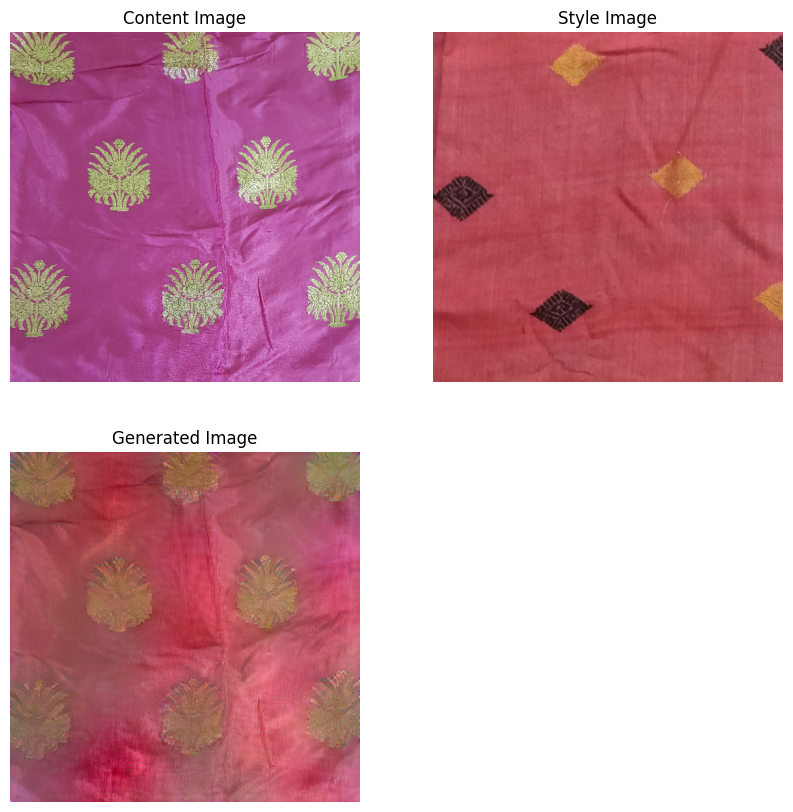

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import os

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

def extract_features(model, inputs, style_layers, content_layers):
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = model(preprocessed_input)
    style_outputs, content_outputs = (outputs[:len(style_layers)], outputs[len(style_layers):])
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
    content_dict = {content_name: value for content_name, value in zip(content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(style_layers, style_outputs)}
    return {'content': content_dict, 'style': style_dict}

def style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    return style_loss + content_loss

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


def display_images(content_path, style_path, generated_image):
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    content_image = tensor_to_image(content_image)
    style_image = tensor_to_image(style_image)
    generated_image = tensor_to_image(generated_image)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0, 0].imshow(content_image)
    axs[0, 0].set_title('Content Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(style_image)
    axs[0, 1].set_title('Style Image')
    axs[0, 1].axis('off')

    axs[1, 0].imshow(generated_image)
    axs[1, 0].set_title('Generated Image')
    axs[1, 0].axis('off')

    axs[1, 1].axis('off')

    plt.show()

# Get all image paths from the 'images' folder
# image_folder = 'images'
# image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('jpg', 'jpeg', 'png'))]


# Create the optimizer outside of the function
# opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

def run_style_transfer(content_path, style_path, lr=0.02, beta1=0.99, epsilon=1e-1, style_weight=1e-2, content_weight=1e4, tv_weight=30, iterations=1000, checkpoint_iterations=100):
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)

    extractor = vgg_layers(style_layers + content_layers)
    style_targets = extract_features(extractor, style_image, style_layers, content_layers)['style']
    content_targets = extract_features(extractor, content_image, style_layers, content_layers)['content']

    # Create the image variable
    image = tf.Variable(content_image)

    # Create a new optimizer for each style transfer operation
    opt = tf.optimizers.Adam(learning_rate=lr, beta_1=beta1, epsilon=epsilon)

    @tf.function
    def train_step():
        with tf.GradientTape() as tape:
            outputs = extract_features(extractor, image, style_layers, content_layers)
            loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers)
            loss += tv_weight * tf.image.total_variation(image)
        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))
        return loss

    step = 0
    for n in range(iterations):
        step += 1
        loss = train_step()

        if step % 10 == 0:
            print(f'Iteration: {step}, Loss: {float(loss):.4f}')

        if step % checkpoint_iterations == 0 or step == iterations:
            print(f'Saving image at iteration {step}')
            img = tensor_to_image(image)
            img.save(f"output_{step}_iter.png")

    file_name = 'stylized-image.png'
    tensor_to_image(image).save(file_name)
    return image

# Modify the train_step function to return the loss
@tf.function
def train_step(image, extractor, style_targets, content_targets, opt, style_weight, content_weight, total_variation_weight, num_style_layers, num_content_layers, style_layers, content_layers):
    with tf.GradientTape() as tape:
        outputs = extract_features(extractor, image, style_layers, content_layers)
        loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss

# Get all image paths from the 'images' folder
image_folder = 'images'
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('jpg', 'jpeg', 'png'))]

# Create a list to store all unique pairs
unique_pairs = []

for content_path in image_paths:
    for style_path in image_paths:
        if content_path != style_path:
            # Add the pair to the list, ensuring we don't add duplicates
            if (content_path, style_path) not in unique_pairs and (style_path, content_path) not in unique_pairs:
                unique_pairs.append((content_path, style_path))

# Now process each unique pair
for content_path, style_path in unique_pairs:
    print(f"Applying style from {style_path} to content {content_path}")
    generated_image = run_style_transfer(
        content_path=content_path,
        style_path=style_path,
        lr=0.02,
        beta1=0.99,
        epsilon=1e-1,
        style_weight=1e-2,
        content_weight=1e4,
        tv_weight=30,
        iterations=1000,
        checkpoint_iterations=100
    )

    display_images(content_path, style_path, generated_image)